<a href="https://colab.research.google.com/github/ThiagoSViana/Bootcamp_Final/blob/main/Prophet_PV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.dates as mdates
months = mdates.MonthLocator()

from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt
from math import sqrt
from numpy import concatenate
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/all_breakdown.csv', usecols=['TIMESTAMP', 'SOLAR PV', 'Hour'])
data = data.sort_values(by=['TIMESTAMP'])
df = data[data['SOLAR PV'].notna()]
print(df.head())

                 TIMESTAMP  Hour  SOLAR PV
35280  2012-11-26 00:00:00   1.0       0.0
35281  2012-11-26 01:00:00   2.0       0.0
35282  2012-11-26 02:00:00   3.0       0.0
35283  2012-11-26 03:00:00   4.0       0.0
35284  2012-11-26 04:00:00   5.0       0.0


In [ ]:
full_data = df

In [ ]:
# converting timestamp column into datetime
full_data['TIMESTAMP'] = pd.to_datetime(full_data['TIMESTAMP'])

# accessing dt
full_data['MONTH'] = full_data['TIMESTAMP'].dt.month
full_data['YEAR'] = full_data['TIMESTAMP'].dt.year
full_data['DAY'] = full_data['TIMESTAMP'].dt.day
full_data['HOUR'] = full_data['TIMESTAMP'].dt.hour

full_data

,TIMESTAMP,Hour,SOLAR PV,MONTH,YEAR,DAY,HOUR
35280,2012-11-26 00:00:00,1.0,0.0,11,2012,26,0
35281,2012-11-26 01:00:00,2.0,0.0,11,2012,26,1
35282,2012-11-26 02:00:00,3.0,0.0,11,2012,26,2
35283,2012-11-26 03:00:00,4.0,0.0,11,2012,26,3
35284,2012-11-26 04:00:00,5.0,0.0,11,2012,26,4
...,...,...,...,...,...,...,...
57115,2018-01-16 19:00:00,20.0,0.0,1,2018,16,19
57116,2018-01-16 20:00:00,21.0,0.0,1,2018,16,20
57117,2018-01-16 21:00:00,22.0,0.0,1,2018,16,21
57118,2018-01-16 22:00:00,23.0,0.0,1,2018,16,22


In [ ]:
full_data[full_data['TIMESTAMP'] > '2012-11-26 00:00:00']

,TIMESTAMP,Hour,SOLAR PV,MONTH,YEAR,DAY,HOUR
35281,2012-11-26 01:00:00,2.0,0.0,11,2012,26,1
35282,2012-11-26 02:00:00,3.0,0.0,11,2012,26,2
35283,2012-11-26 03:00:00,4.0,0.0,11,2012,26,3
35284,2012-11-26 04:00:00,5.0,0.0,11,2012,26,4
35285,2012-11-26 05:00:00,6.0,0.0,11,2012,26,5
...,...,...,...,...,...,...,...
57115,2018-01-16 19:00:00,20.0,0.0,1,2018,16,19
57116,2018-01-16 20:00:00,21.0,0.0,1,2018,16,20
57117,2018-01-16 21:00:00,22.0,0.0,1,2018,16,21
57118,2018-01-16 22:00:00,23.0,0.0,1,2018,16,22


In [ ]:
full_data.isnull().sum()

TIMESTAMP    0
Hour         0
SOLAR PV     0
MONTH        0
YEAR         0
DAY          0
HOUR         0
dtype: int64

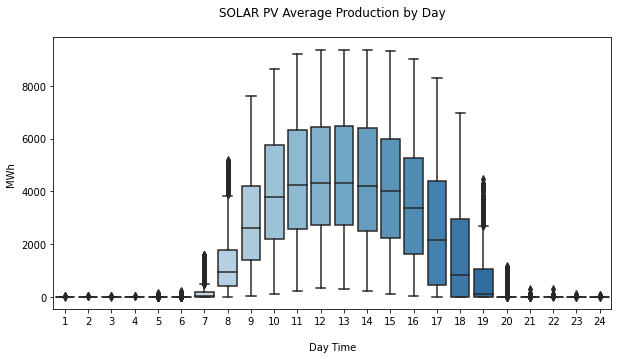

In [ ]:
# taking a look at the general daily trend in solar photovoltaic production 
partial_data = pd.DataFrame(full_data.loc[full_data.TIMESTAMP > pd.to_datetime('2012-11-26 00:00:00'),['SOLAR PV','Hour']])
partial_data.Hour = partial_data.Hour.map(lambda x : int(x))
for i in partial_data.columns[:-1]:
    plt.figure(figsize=(10,5))
    sns.boxplot(partial_data['Hour'],partial_data[i], palette='Blues')

    plt.title('{} Average Production by Day\n'.format(i))
    plt.xlabel('\nDay Time')

    plt.ylabel("MWh ")

plt.show()

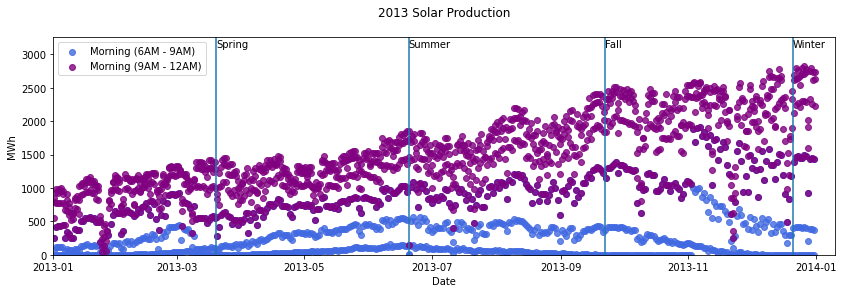

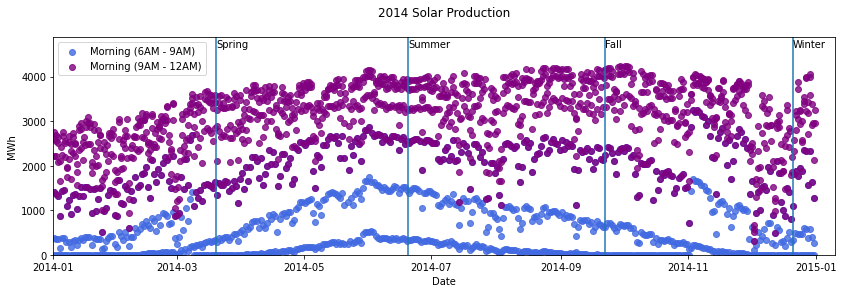

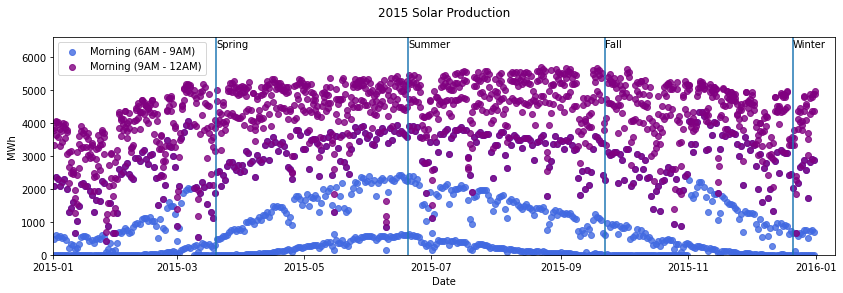

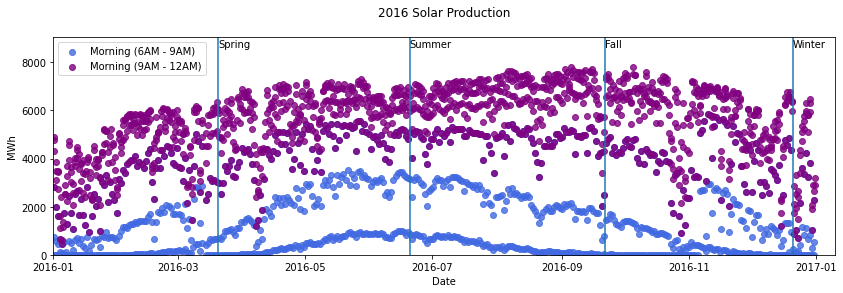

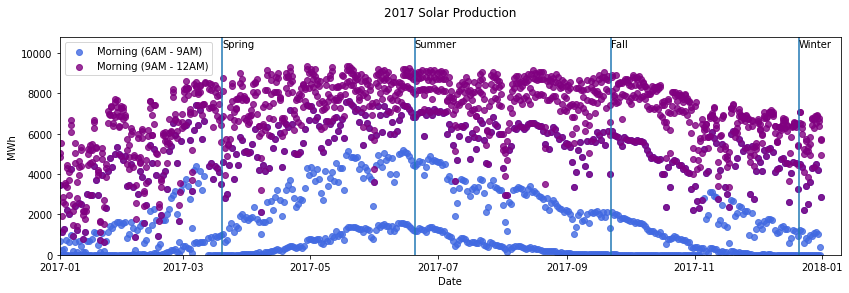

In [ ]:
# taking a look into the total solar photovoltaic production by year in dataset 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() #to make the datetime work

for year in range(2013,2018):
    data = full_data.loc[full_data['YEAR']==year,:]
    hour = data.loc[:,'Hour'].values
    mask_early_morning = ((hour > 6)&(hour <= 9))
    mask_late_morning = ((hour >= 9)&(hour <= 12))   
    x = data['TIMESTAMP']
    y = data['SOLAR PV']
    plt.figure(figsize=(14,4))
    plt.scatter(x[mask_early_morning], y[mask_early_morning],c='royalblue',alpha=.8,label='Morning (6AM - 9AM)')
    plt.scatter(x[mask_late_morning], y[mask_late_morning],c='purple',alpha=.8,label='Morning (9AM - 12AM)')   
    plt.ylim(0,y.max()*1.15)
    plt.xlim(pd.to_datetime('01/01/{}'.format(year)),pd.to_datetime('01/10/{}'.format(year+1)))
    plt.ylabel('MWh')
    plt.xlabel('Date')
    plt.title('{} Solar Production\n'.format(year))
    plt.legend(loc='upper left')
    seasons = [(pd.to_datetime('June 20, {}'.format(year)), 'Summer'),
           (pd.to_datetime('December 21, {}'.format(year)), 'Winter'),
           (pd.to_datetime('September 22, {}'.format(year)), 'Fall'),
           (pd.to_datetime('March 20, {}'.format(year)), 'Spring')]
    for date,season in seasons:
        plt.axvline(date)
        plt.text(date,y.max()*1.1,season)
    plt.show() 

## Using Prophet

In [ ]:
# creating the dataframe for apply fb_prophet
model_data_pv = pd.DataFrame(full_data.loc[full_data.TIMESTAMP.dt.year > 2013,['TIMESTAMP', 'SOLAR PV']])

model_data_pv.columns = ['ds','y']
model_data_pv.sort_values('ds', inplace=True)

display(model_data_pv.head())
# splitting the last year as our testing year
train_pv = model_data_pv.loc[model_data_pv.ds.dt.year < 2017,:]
test_pv = model_data_pv.loc[model_data_pv.ds.dt.year >= 2017,:] 

,ds,y
17040,2014-01-01 00:00:00,0.0
17041,2014-01-01 01:00:00,0.0
17042,2014-01-01 02:00:00,0.0
17043,2014-01-01 03:00:00,0.0
17044,2014-01-01 04:00:00,0.0


In [ ]:
# model
def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month >= 3) & (date.month <= 9))


# creating daily seasonality
model_data_pv['on_season'] = model_data_pv['ds'].apply(on_season)
model_data_pv['off_season'] = ~model_data_pv['ds'].apply(on_season)
model_data_pv['cap'] = 12000

model_data_pv.y = np.cbrt(model_data_pv.y)
model_data_pv.cap = np.cbrt(model_data_pv.cap)
display(model_data_pv.head())

train = model_data_pv.loc[model_data_pv.ds.dt.year < 2017,:]
test = model_data_pv.loc[model_data_pv.ds.dt.year >= 2017, :] 

,ds,y,on_season,off_season,cap
17040,2014-01-01 00:00:00,0.0,False,True,22.894285
17041,2014-01-01 01:00:00,0.0,False,True,22.894285
17042,2014-01-01 02:00:00,0.0,False,True,22.894285
17043,2014-01-01 03:00:00,0.0,False,True,22.894285
17044,2014-01-01 04:00:00,0.0,False,True,22.894285


In [ ]:
model = Prophet(changepoint_range=.8,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=.01,seasonality_prior_scale=20)

model.add_seasonality(name='on_season_daily', period=1, condition_name='on_season', fourier_order=6)
model.add_seasonality(name='off_season_daily', period=1, condition_name='off_season', fourier_order=6)

model.fit(train)

In [ ]:
future = model.make_future_dataframe(periods=1460*24, freq='H')

future['on_season'] = future['ds'].apply(on_season)
future['off_season'] = ~future['ds'].apply(on_season)
future['cap'] = 16000
future.cap = np.cbrt(future.cap)

forecast = model.predict(future) 

<Figure size 1440x1080 with 0 Axes>

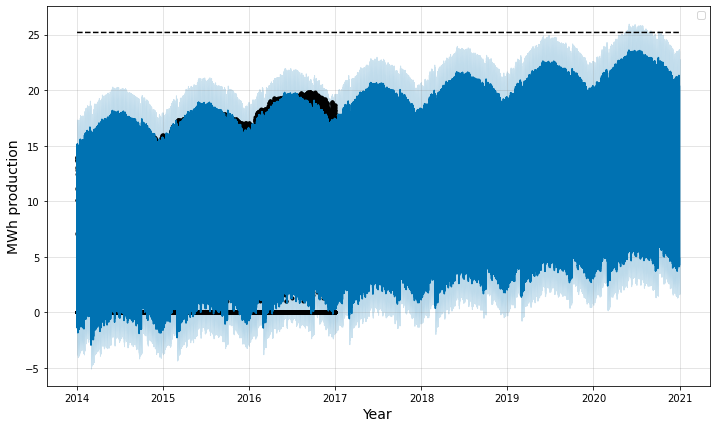

In [ ]:
plt.figure(figsize=(20,15))

fig = model.plot(forecast)
plt.xlabel('Year', fontsize=14)
plt.ylabel('MWh production', fontsize=14)
plt.legend()
plt.show()

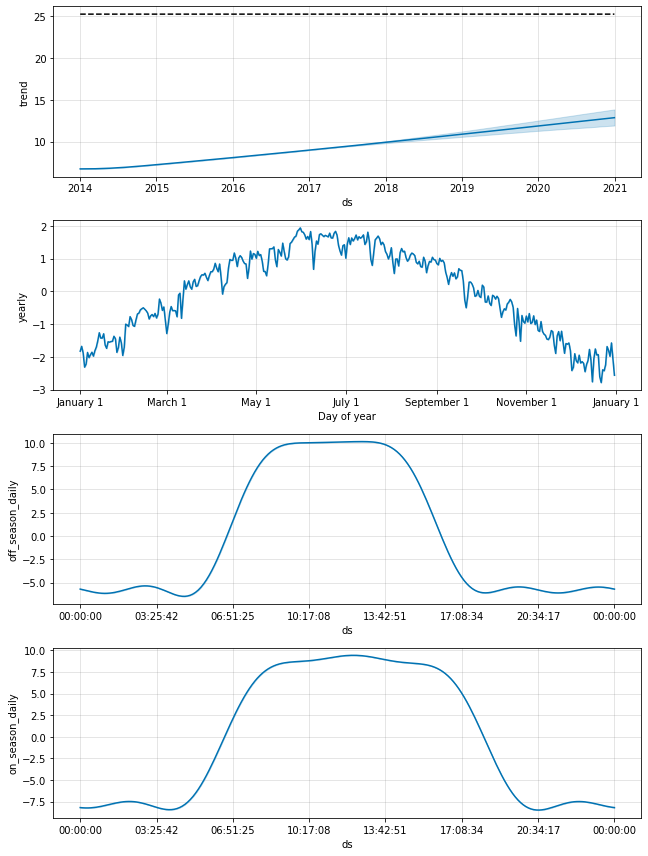

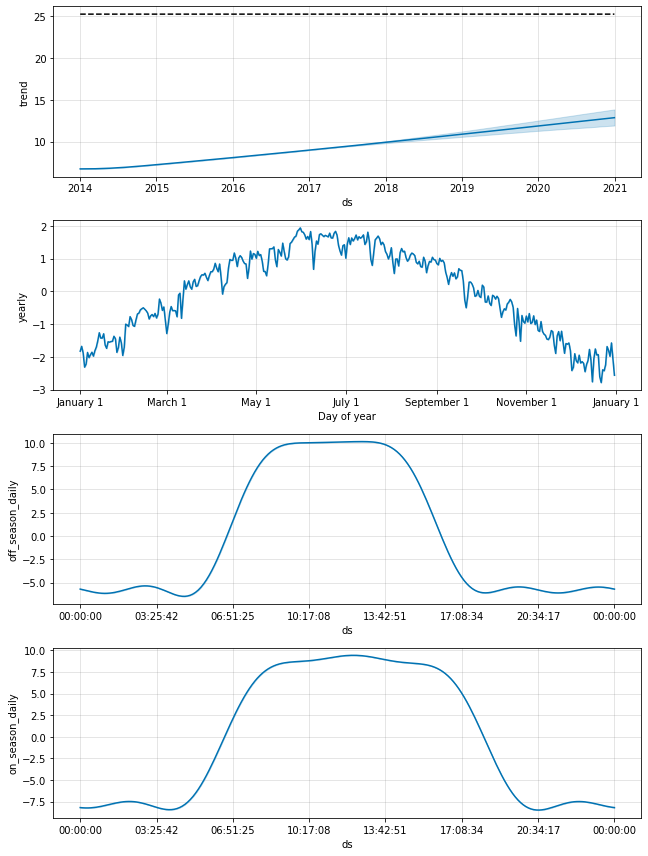

In [ ]:
model.plot_components(forecast) 

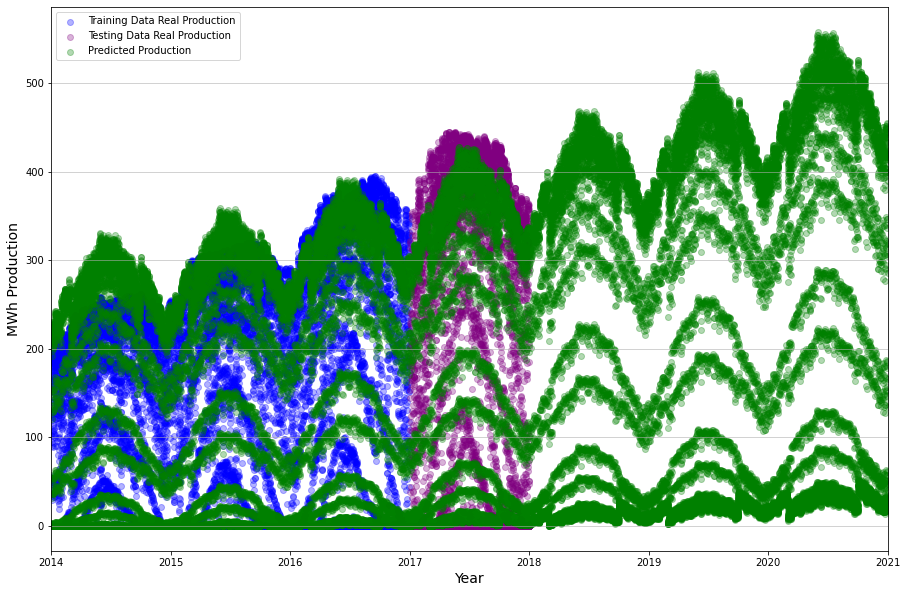

In [ ]:
train.y = train.y**2
test.y = test.y**2
forecast.yhat = forecast.yhat**2

plt.figure(figsize=(15,10))

plt.scatter(train['ds'],train['y'], color='b',alpha=.3,label='Training Data Real Production')
plt.scatter(test['ds'],test['y'],color='purple',alpha=.3,label='Testing Data Real Production')
plt.scatter(forecast['ds'],forecast['yhat'],color='green',alpha=.3,label='Predicted Production')

plt.xlim(pd.to_datetime('2014-01-01'),pd.to_datetime('2021-01-01'))
plt.ylabel('MWh Production', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)

plt.show() 

In [ ]:
forecast_Train = forecast.loc[forecast.ds.dt.year < 2017,:]
forecast_Test = forecast.loc[forecast.ds.dt.year >= 2017,:]

forecast_Test.set_index(pd.DatetimeIndex(forecast_Test.ds), inplace=True)
test = test.loc[test.ds.dt.year == 2017,:]
test.set_index(pd.DatetimeIndex(test.ds), inplace=True)

testDf = forecast_Test.merge(test, how='outer', right_index=True, left_index=True)
testDf.y = testDf.y.fillna(0)
testDf.yhat = testDf.yhat.fillna(0)

print("Train R2 Score: ", r2_score(train.y, forecast_Train.yhat))
print("Train MAE: ", mean_absolute_error(train.y, forecast_Train.yhat))

Train R2 Score:  0.9377899600335288
Train MAE:  18.468503458967756
Test R2 Score:  -3.452674815104417
Test MAE:  144.8261514658608


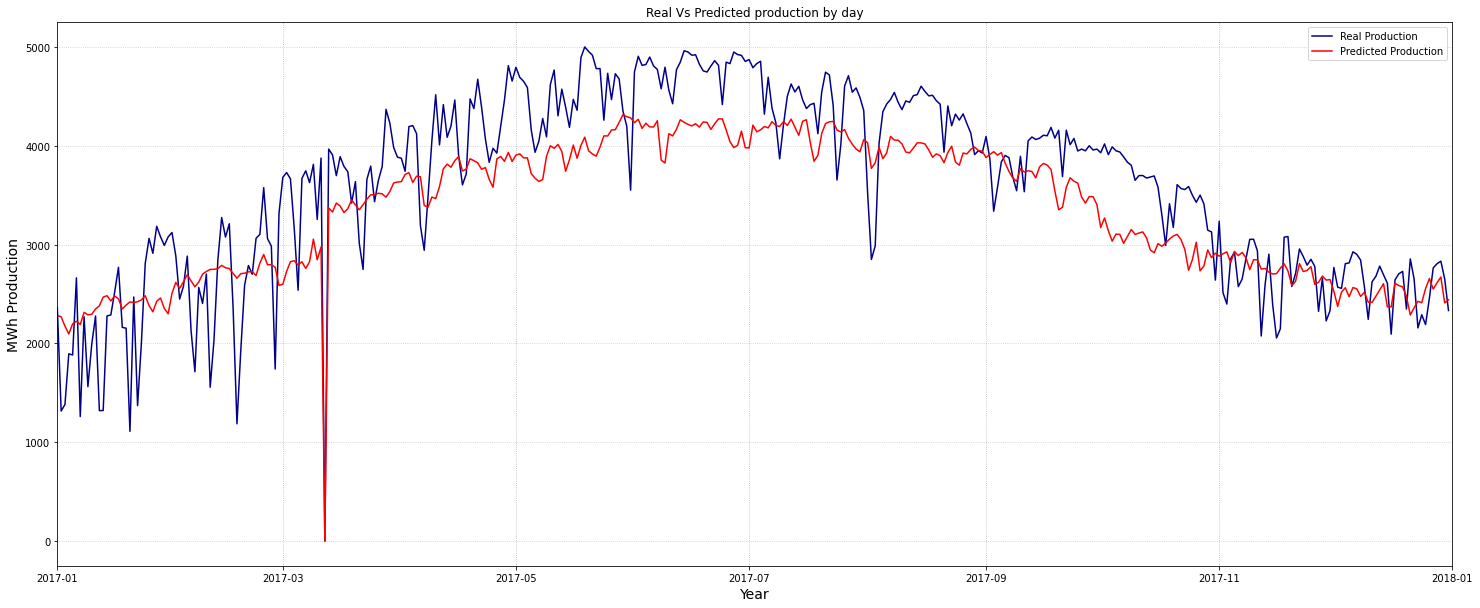

Predicted 2017 Solar PV : 1219.94 GWh
Real 2017 Solar PV :  1316.03 GWh
Total Year Error (%) :  7.3 %


In [ ]:
# group the data for better accuracy of this version
plot = testDf[['y','yhat']]

plot = plot.resample('24H').sum()

plt.figure(figsize=(25,10))
plt.plot(plot.index, plot.y, label="Real Production", color='darkblue')
plt.plot(plot.index, plot.yhat, label="Predicted Production", color='r')
plt.legend()
plt.title("Real Vs Predicted production by day")
plt.grid(linestyle=":")
plt.xlim(pd.to_datetime('2017-01-01'),pd.to_datetime('2018-01-01'))

plt.ylabel('MWh Production', fontsize =14)
plt.xlabel('Year', fontsize = 14)
plt.legend()
plt.grid(axis='y',alpha=.7)
plt.show()

print("Predicted 2017 Solar PV :", round(plot.yhat.sum() / 1000,2), "GWh")
print("Real 2017 Solar PV : ", round(plot.y.sum() / 1000,2), "GWh")
print("Total Year Error (%) : ", round(((np.abs(plot.yhat.sum() - plot.y.sum()))/ plot.y.sum()) * 100,2), "%") 